## Car Price Optimization Project

## Introduction

### Research Background
Understanding key factors influencing car pricing is critical for manufacturers to target
distinct market segments. Pricing categories (Low, Mid, and High) depend on various
vehicle features, and identifying patterns can lead to improved market strategies. The
goal of this project is to uncover relationships between these factors and pricing.

- Dataset : https://www.kaggle.com/datasets/CooperUnion/cardataset

In [37]:
# load the library
library(ggplot2)
library(tidyverse)
library(dplyr)
library(MASS)  # For LDA
library(car)  # For MANOVA
library(psych)  # For Factor Analysis
library(corrplot)
library(e1071)
library(klaR)
library(gridExtra)
library(useful)
library(factoextra)
library(aplpack)

# 0. Data preprocessing

##  1) Dropping missing value

In [38]:
# load the data
data <- read.csv("data.csv")
sum(is.na(data))
str(data)
#sum(is.na(data))  # Total number of missing values in the dataset
dat <- na.omit(data)  # remove rows with missing values
sum(is.na(dat))
summary(dat[, c(3, 5, 6, 9, 13:15, 16)])

head(dat)

[1] 105

'data.frame':	11914 obs. of  16 variables:
 $ Make             : chr  "Bugatti" "Bugatti" "Bugatti" "Lamborghini" ...
 $ Model            : chr  "Veyron 16.4" "Veyron 16.4" "Veyron 16.4" "Aventador" ...
 $ Year             : int  2008 2009 2008 2016 2016 2015 2013 2014 2014 2015 ...
 $ Engine.Fuel.Type : chr  "premium unleaded (required)" "premium unleaded (required)" "premium unleaded (required)" "premium unleaded (required)" ...
 $ Engine.HP        : int  1001 1001 1001 750 750 731 731 731 720 720 ...
 $ Engine.Cylinders : int  16 16 16 12 12 12 12 12 12 12 ...
 $ Transmission.Type: chr  "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" ...
 $ Driven_Wheels    : chr  "all wheel drive" "all wheel drive" "all wheel drive" "all wheel drive" ...
 $ Number.of.Doors  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Market.Category  : chr  "Exotic,High-Performance" "Exotic,High-Performance" "Exotic,High-Performance" "Exotic,High-Performance" ...
 $ Vehicle.Size     : chr  "Compac

[1] 0

      Year        Engine.HP      Engine.Cylinders Number.of.Doors
 Min.   :1990   Min.   :  55.0   Min.   : 0.00    Min.   :2.000  
 1st Qu.:2007   1st Qu.: 170.0   1st Qu.: 4.00    1st Qu.:2.000  
 Median :2015   Median : 227.0   Median : 6.00    Median :4.000  
 Mean   :2010   Mean   : 249.5   Mean   : 5.65    Mean   :3.433  
 3rd Qu.:2016   3rd Qu.: 300.0   3rd Qu.: 6.00    3rd Qu.:4.000  
 Max.   :2017   Max.   :1001.0   Max.   :16.00    Max.   :4.000  
  highway.MPG        city.mpg        Popularity        MSRP        
 Min.   : 12.00   Min.   :  7.00   Min.   :   2   Min.   :   2000  
 1st Qu.: 22.00   1st Qu.: 16.00   1st Qu.: 549   1st Qu.:  20990  
 Median : 26.00   Median : 18.00   Median :1385   Median :  29960  
 Mean   : 26.32   Mean   : 19.33   Mean   :1553   Mean   :  40554  
 3rd Qu.: 30.00   3rd Qu.: 22.00   3rd Qu.:2009   3rd Qu.:  42200  
 Max.   :354.00   Max.   :137.00   Max.   :5657   Max.   :2065902  

,Make,Model,Year,Engine.Fuel.Type,Engine.HP,Engine.Cylinders,Transmission.Type,Driven_Wheels,Number.of.Doors,Market.Category,Vehicle.Size,Vehicle.Style,highway.MPG,city.mpg,Popularity,MSRP
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,"Exotic,High-Performance",Compact,Coupe,14,8,820,2065902
2,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,"Exotic,High-Performance",Compact,Coupe,14,8,820,1705769
3,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,"Exotic,High-Performance",Compact,Coupe,14,8,820,1500000
4,Lamborghini,Aventador,2016,premium unleaded (required),750,12,AUTOMATED_MANUAL,all wheel drive,2,"Exotic,High-Performance",Midsize,Convertible,18,11,1158,535500
5,Lamborghini,Aventador,2016,premium unleaded (required),750,12,AUTOMATED_MANUAL,all wheel drive,2,"Exotic,High-Performance",Midsize,Coupe,18,11,1158,490700
6,Ferrari,F12 Berlinetta,2015,premium unleaded (required),731,12,AUTOMATED_MANUAL,rear wheel drive,2,"Exotic,High-Performance",Midsize,Coupe,16,11,2774,319995


# Boxplot for checking outlier

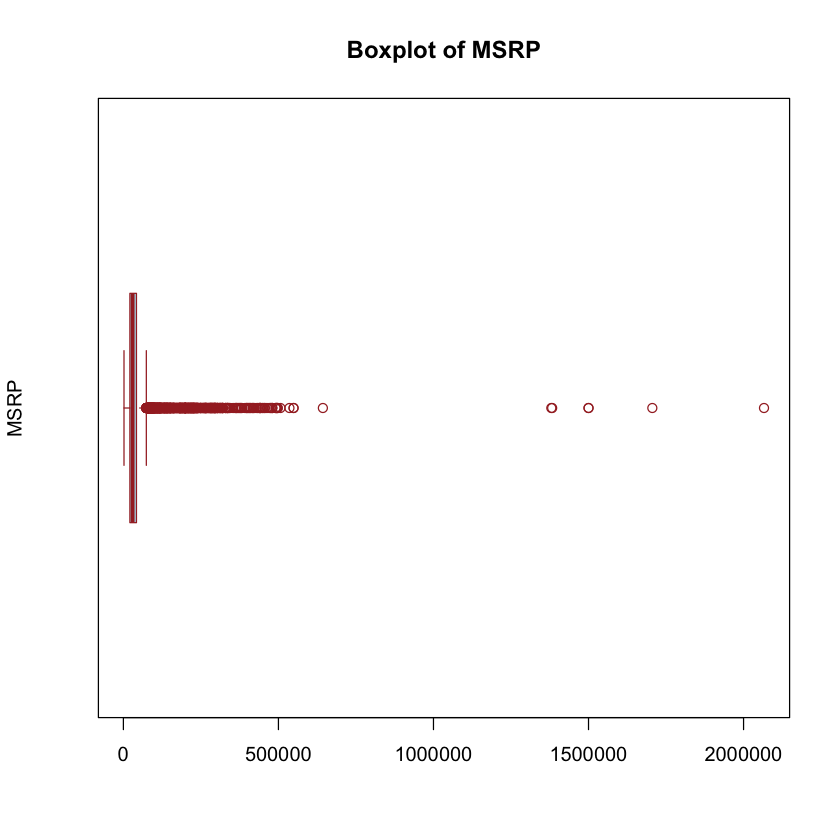

In [3]:
#boxplot of msrp

boxplot(dat$MSRP, main="Boxplot of MSRP", ylab="MSRP", col="lightblue", border="brown", horizontal=TRUE)

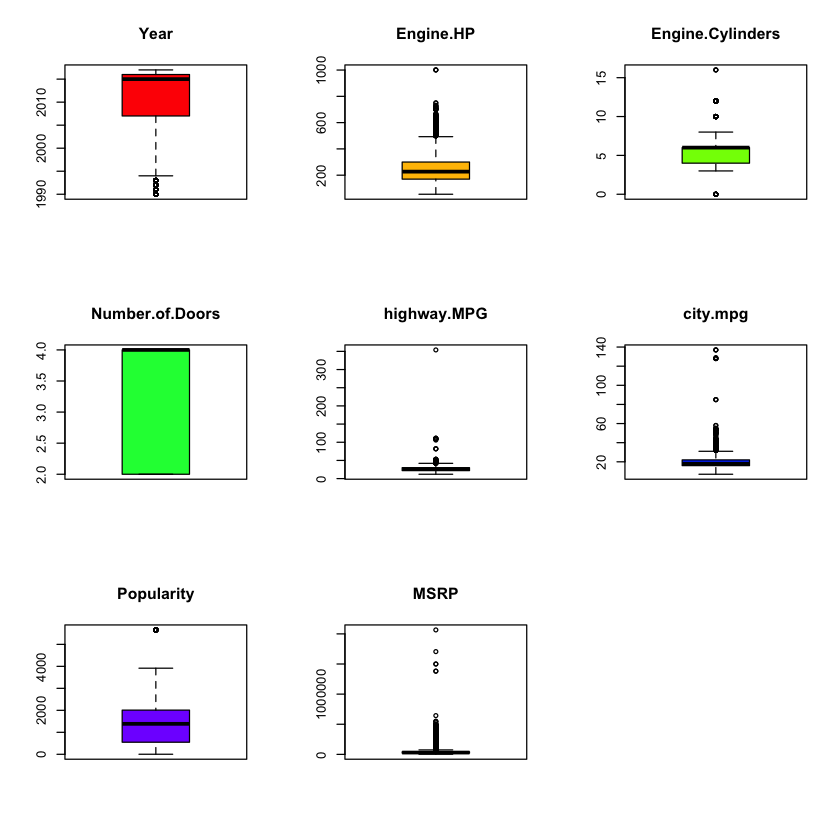

In [4]:
selected_vars <- dat[, c(3, 5, 6, 9, 13:15, 16)]  

par(mfrow = c(3, 3))  

colors <- rainbow(ncol(selected_vars))
for (i in 1:ncol(selected_vars)) {
  boxplot(selected_vars[, i], 
          main = colnames(selected_vars)[i], 
          col = colors[i])
}

# 2) Dropping outlier

In [5]:
# Function to remove outliers using IQR method
remove_outliers <- function(data, cols) {
  for (col in cols) {
    Q1 <- quantile(data[[col]], 0.25, na.rm = TRUE)  # 1st Quartile (25%)
    Q3 <- quantile(data[[col]], 0.75, na.rm = TRUE)  # 3rd Quartile (75%)
    IQR <- Q3 - Q1                                  # Interquartile Range
    
    # Define lower and upper bounds
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    
    # Filter rows within bounds
    data <- data[data[[col]] >= lower_bound & data[[col]] <= upper_bound, ]
  }
  return(data)
}

numeric_cols <- c("Engine.HP","MSRP")
dat <- remove_outliers(dat, numeric_cols)

# Check the cleaned data
summary(dat[, c(3, 5, 6, 9, 13:15, 16)])


      Year        Engine.HP   Engine.Cylinders Number.of.Doors  highway.MPG    
 Min.   :1990   Min.   : 55   Min.   : 0.000   Min.   :2.000   Min.   : 12.00  
 1st Qu.:2006   1st Qu.:168   1st Qu.: 4.000   1st Qu.:3.000   1st Qu.: 22.00  
 Median :2014   Median :210   Median : 6.000   Median :4.000   Median : 26.00  
 Mean   :2010   Mean   :226   Mean   : 5.354   Mean   :3.489   Mean   : 26.84  
 3rd Qu.:2016   3rd Qu.:285   3rd Qu.: 6.000   3rd Qu.:4.000   3rd Qu.: 31.00  
 Max.   :2017   Max.   :485   Max.   :12.000   Max.   :4.000   Max.   :354.00  
    city.mpg        Popularity        MSRP      
 Min.   : 10.00   Min.   :  21   Min.   : 2000  
 1st Qu.: 16.00   1st Qu.: 549   1st Qu.:19950  
 Median : 19.00   Median :1385   Median :28230  
 Mean   : 19.84   Mean   :1563   Mean   :28260  
 3rd Qu.: 22.00   3rd Qu.:2009   3rd Qu.:37891  
 Max.   :137.00   Max.   :5657   Max.   :69340  

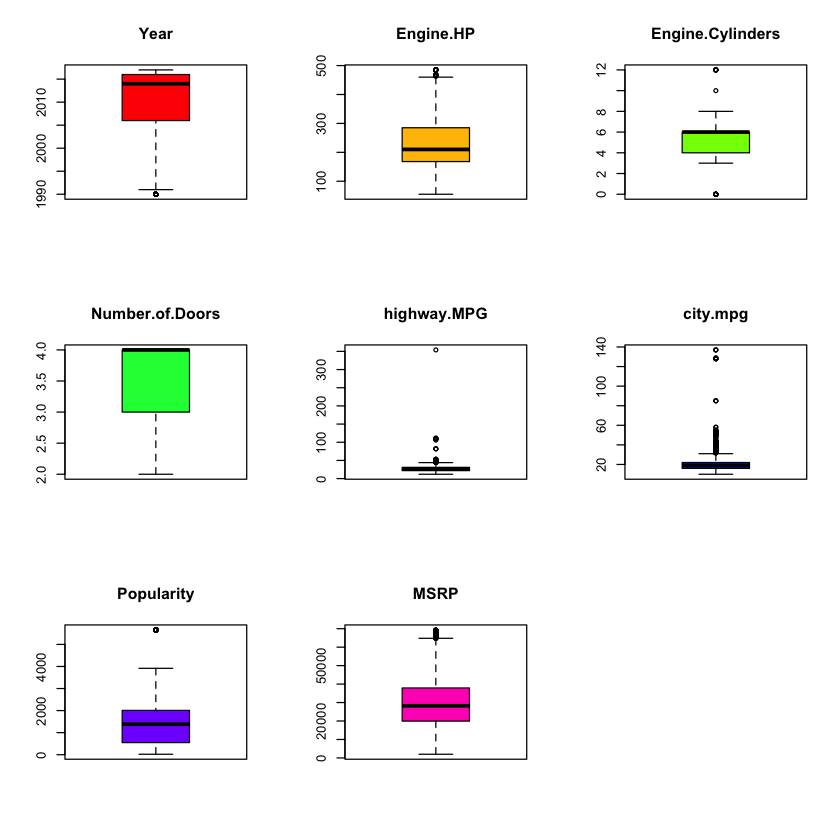

In [6]:
selected_vars <- dat[, c(3, 5, 6, 9, 13:15, 16)]  

par(mfrow = c(3, 3))  

colors <- rainbow(ncol(selected_vars))
for (i in 1:ncol(selected_vars)) {
  boxplot(selected_vars[, i], 
          main = colnames(selected_vars)[i], 
          col = colors[i])
}



In [7]:
# str(dat)
# summary(dat)

# summary of factor variables 
# summary(data[,c(1:2,4,7,8,10:12)])
str(data[,c(1:2,4,7,8,10:12)])

# summary of numeric variables
# summary(data[,c(3,5,6,9,13:16)])
str(data[,c(3,5,6,9,13:16)])


'data.frame':	11914 obs. of  8 variables:
 $ Make             : chr  "Bugatti" "Bugatti" "Bugatti" "Lamborghini" ...
 $ Model            : chr  "Veyron 16.4" "Veyron 16.4" "Veyron 16.4" "Aventador" ...
 $ Engine.Fuel.Type : chr  "premium unleaded (required)" "premium unleaded (required)" "premium unleaded (required)" "premium unleaded (required)" ...
 $ Transmission.Type: chr  "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" "AUTOMATED_MANUAL" ...
 $ Driven_Wheels    : chr  "all wheel drive" "all wheel drive" "all wheel drive" "all wheel drive" ...
 $ Market.Category  : chr  "Exotic,High-Performance" "Exotic,High-Performance" "Exotic,High-Performance" "Exotic,High-Performance" ...
 $ Vehicle.Size     : chr  "Compact" "Compact" "Compact" "Midsize" ...
 $ Vehicle.Style    : chr  "Coupe" "Coupe" "Coupe" "Convertible" ...
'data.frame':	11914 obs. of  8 variables:
 $ Year            : int  2008 2009 2008 2016 2016 2015 2013 2014 2014 2015 ...
 $ Engine.HP       : int  1001 1001 1001

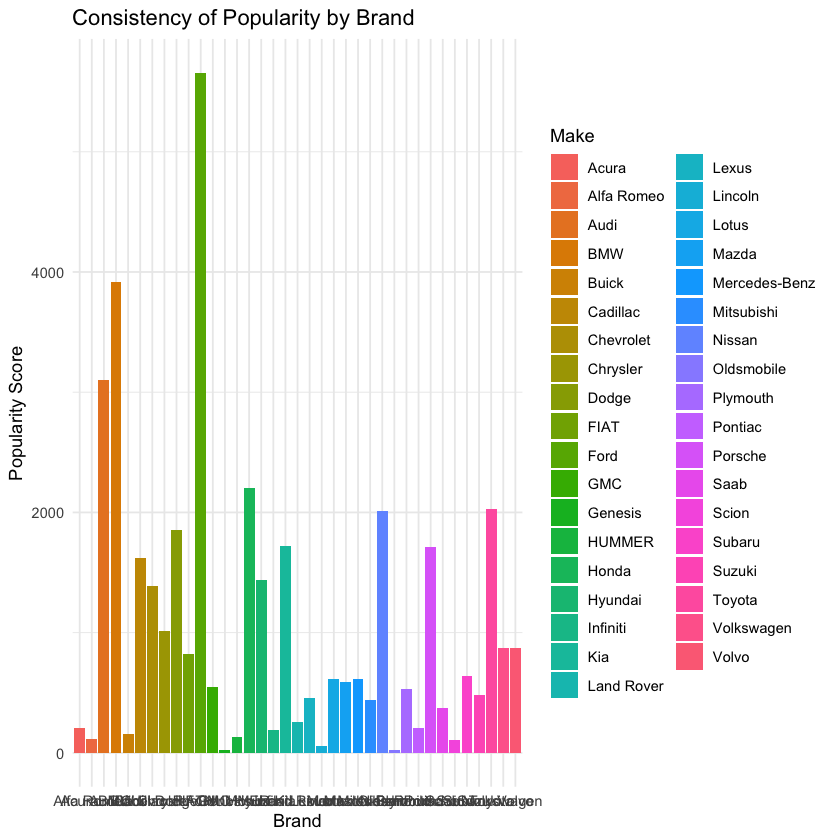

In [8]:
library(ggplot2)

# Example: Create a bar plot showing the brand-wise popularity consistency
popularity_summary <- dat %>%
  group_by(Make) %>%
  summarize(Popularity = unique(Popularity))

ggplot(popularity_summary, aes(x = Make, y = Popularity, fill = Make)) +
  geom_bar(stat = "identity") +
  labs(title = "Consistency of Popularity by Brand", x = "Brand", y = "Popularity Score") +
  theme_minimal()


### same brand has same popularity value

In [9]:
# Select only categorical variables from your dataset
categorical_vars <- c("Make", "Model", "Engine.Fuel.Type", "Transmission.Type", 
                      "Driven_Wheels", "Market.Category", "Vehicle.Size", "Vehicle.Style")

# Create a summary table of unique counts
categorical_summary <- sapply(dat[categorical_vars], function(x) length(unique(x)))

# Convert to a data frame for easy display
summary_table <- data.frame(
  Variable = names(categorical_summary),
  Unique_Values = as.integer(categorical_summary)
)

# Display the summary table
print(summary_table)


           Variable Unique_Values
1              Make            37
2             Model           769
3  Engine.Fuel.Type            10
4 Transmission.Type             5
5     Driven_Wheels             4
6   Market.Category            57
7      Vehicle.Size             3
8     Vehicle.Style            16


Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(2, at = yt, ...):
""na.rm" is not a graphical parameter"
Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(2, at = yt, ...):
""na.rm" is not a graphical parameter"
Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphic

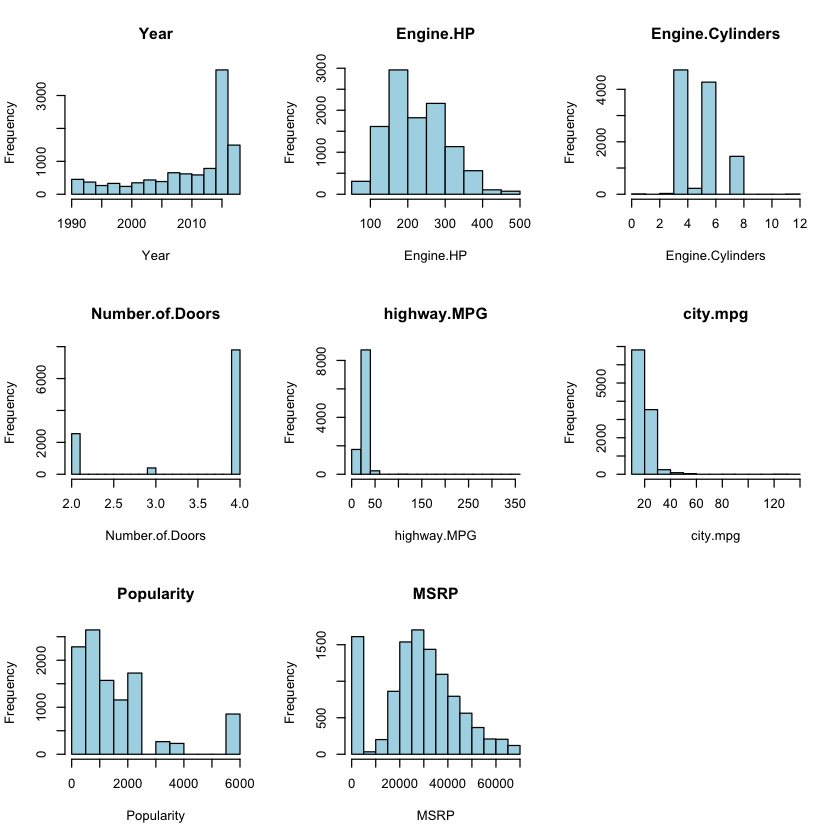

In [10]:

num_colname <- colnames(dat)[c(3,5,6,9,13,14,15,16)]

par(mfrow = c(3,3)) 

for (var in num_colname) {
    hist(as.numeric(dat[[var]]),
         main = var,
         xlab = var,
         col = "lightblue",
         border = "black",
         na.rm = TRUE)
}


In [11]:
#calculate the skewness and kurtosis of the numeric variables
skewness <- sapply(dat[, c(3, 5, 6, 9, 13:16)], skewness)
kurtosis <- sapply(dat[, c(3, 5, 6, 9, 13:16)], kurtosis)
skewness
kurtosis

Year        Engine.HP Engine.Cylinders  Number.of.Doors 
     -1.12581293       0.45615180       0.53054207      -1.12027763 
     highway.MPG         city.mpg       Popularity             MSRP 
      9.30863376       5.79637644       1.68996686       0.05814391

Year        Engine.HP Engine.Cylinders  Number.of.Doors 
      0.01939284      -0.28269098      -0.33388653      -0.67830283 
     highway.MPG         city.mpg       Popularity             MSRP 
    348.70877679      80.88513875       2.35167435      -0.26284641

# 3) Log transformation 
# 4) Scaling and Standardization

In [12]:
dat <- dat %>% 
mutate(across(c(highway.MPG,city.mpg,Popularity), ~ log1p(.)))


num_dat = dat[,c(3,5,6,9,13,14,15,16)]
num_dat = data.frame(scale(num_dat,center=TRUE,scale = TRUE))

str(num_dat)
head(num_dat)


'data.frame':	10736 obs. of  8 variables:
 $ Year            : num  0.893 0.765 0.765 0.893 0.637 ...
 $ Engine.HP       : num  3.34 3.34 3.34 3.34 3.34 ...
 $ Engine.Cylinders: num  1.87 1.87 1.87 1.87 1.87 ...
 $ Number.of.Doors : num  0.6 0.6 -1.75 -1.75 0.6 ...
 $ highway.MPG     : num  -0.175 -0.175 -0.519 -0.519 -0.175 ...
 $ city.mpg        : num  -0.923 -0.923 -1.182 -1.182 -0.923 ...
 $ Popularity      : num  0.582 0.582 0.582 0.582 0.582 ...
 $ MSRP            : num  1.47 1.46 1.35 1.35 1.27 ...


,Year,Engine.HP,Engine.Cylinders,Number.of.Doors,highway.MPG,city.mpg,Popularity,MSRP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
515,0.8932088,3.340606,1.867996,0.6004108,-0.1745389,-0.9228825,0.5819038,1.470491
516,0.7649916,3.340606,1.867996,0.6004108,-0.1745389,-0.9228825,0.5819038,1.460853
517,0.7649916,3.340606,1.867996,-1.7500032,-0.5191480,-1.1817378,0.5819038,1.345192
518,0.8932088,3.340606,1.867996,-1.7500032,-0.5191480,-1.1817378,0.5819038,1.345192
519,0.6367745,3.340606,1.867996,0.6004108,-0.1745389,-0.9228825,0.5819038,1.268085
520,0.6367745,3.340606,1.867996,-1.7500032,-0.5191480,-1.1817378,0.5819038,1.120297


In [13]:
library(e1071)
apply(num_dat, 2, skewness)  

Year        Engine.HP Engine.Cylinders  Number.of.Doors 
     -1.12581293       0.45615180       0.53054207      -1.12027763 
     highway.MPG         city.mpg       Popularity             MSRP 
      0.26149274       0.94242142      -0.78685469       0.05814391

# 5) Data Sampling(3000)
# 6) Grouping by price

In [14]:
set.seed(123)
dat <- dat[sample(1:nrow(dat), 3000, replace = FALSE), ]

# Set quantile thresholds for MSRP
msrp_threshold <- quantile(dat$MSRP, probs = c(0.33, 0.67))

# Categorize cars into 'Low', 'Mid', and 'High' based on MSRP
dat$MSRP_Group <- ifelse(
  dat$MSRP <= msrp_threshold[1], "Low",
  ifelse(dat$MSRP <= msrp_threshold[2], "Mid", "High")
)
# Convert to factor for further analysis
dat$MSRP_Group <- as.factor(dat$MSRP_Group)

# Calculate the range for each MSRP group
dat %>%
  group_by(MSRP_Group) %>%
  summarize(
    Min_MSRP = min(MSRP),
    Max_MSRP = max(MSRP)
  ) %>%
  arrange(factor(MSRP_Group, levels = c("Low", "Mid", "High")))

  # Verify the grouping
table(dat$MSRP_Group)

MSRP_Group,Min_MSRP,Max_MSRP
<fct>,<int>,<int>
Low,2000,22990
Mid,22995,34490
High,34500,69100



High  Low  Mid 
 990  990 1020 

,Year,Engine.HP,Engine.Cylinders,Number.of.Doors,highway.MPG,city.mpg,Popularity,MSRP
Year,1.0000000,0.38968588,-0.11899362,0.30716657,0.369050531,0.32845688,0.14891886,0.703091479
Engine.HP,0.3896859,1.00000000,0.69066564,0.09204418,-0.410691381,-0.49379667,0.05129331,0.728772663
Engine.Cylinders,-0.1189936,0.69066564,1.00000000,-0.01275671,-0.725127305,-0.75711920,0.04113899,0.280084563
Number.of.Doors,0.3071666,0.09204418,-0.01275671,1.00000000,0.086881907,0.09314125,-0.06629592,0.222491300
highway.MPG,0.3690505,-0.41069138,-0.72512731,0.08688191,1.000000000,0.93490400,-0.02370326,-0.007785589
city.mpg,0.3284569,-0.49379667,-0.75711920,0.09314125,0.934904001,1.00000000,0.01423968,-0.068043775
Popularity,0.1489189,0.05129331,0.04113899,-0.06629592,-0.023703265,0.01423968,1.00000000,0.017544631
MSRP,0.7030915,0.72877266,0.28008456,0.22249130,-0.007785589,-0.06804378,0.01754463,1.000000000


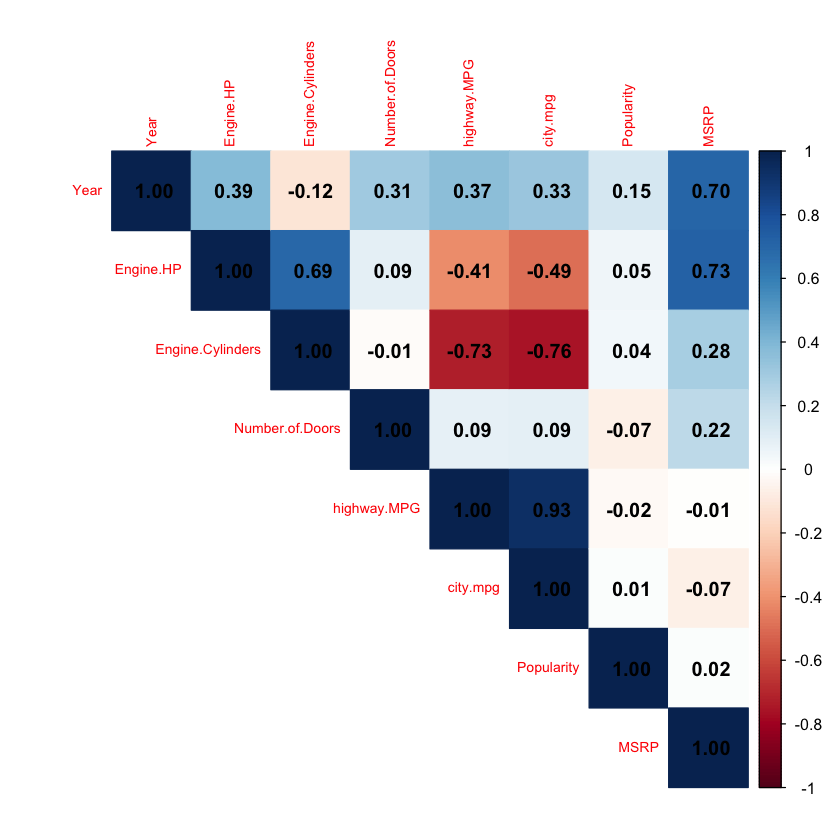

In [15]:
#correlation matrix 
cor.mat=cor(num_dat)
# corrplot(cor.mat)


cor(num_dat) #city mpg and highway mpg are highly correlated
# num_dat <- num_dat[,-7] #remove highway mpg


corrplot(cor.mat, method = "color",type = "upper", tl.cex = 0.7, addCoef.col = "black")

Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(2, at = yt, ...):
""na.rm" is not a graphical parameter"
Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(2, at = yt, ...):
""na.rm" is not a graphical parameter"
Warning message in plot.window(xlim, ylim, "", ...):
""na.rm" is not a graphical parameter"
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
""na.rm" is not a graphical parameter"
Warning message in axis(1, ...):
""na.rm" is not a graphic

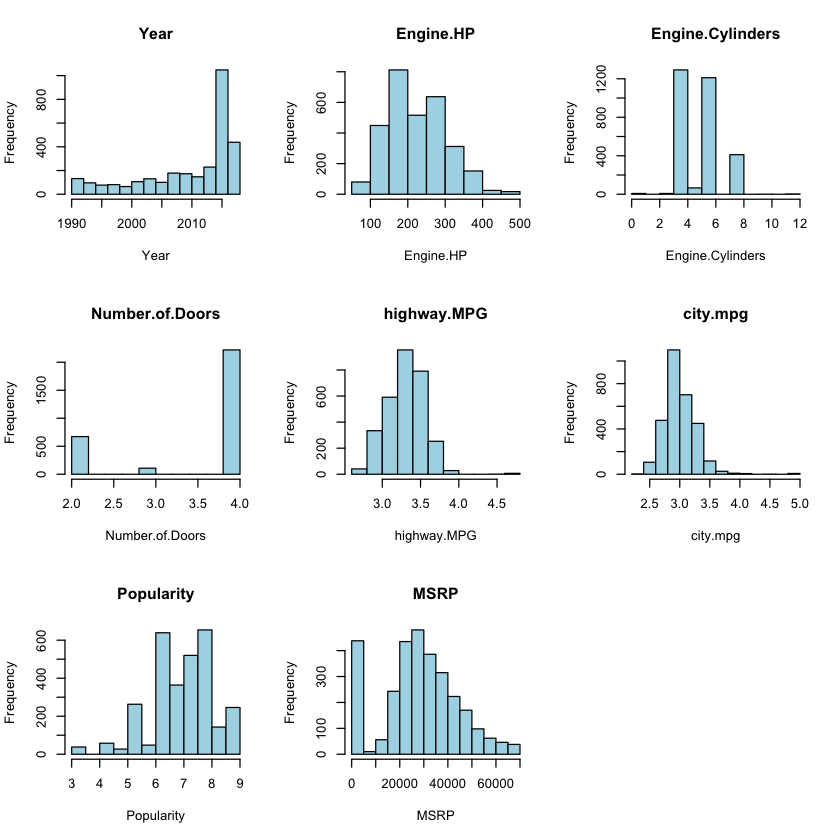

In [16]:

num_colname <- colnames(dat)[c(3,5,6,9,13,14,15,16)]

par(mfrow = c(3,3)) 
for (var in num_colname) {
    hist(as.numeric(dat[[var]]),
         main = var,
         xlab = var,
         col = "lightblue",
         border = "black",
         na.rm = TRUE)
}

# 1) QQ plot for checking normality

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


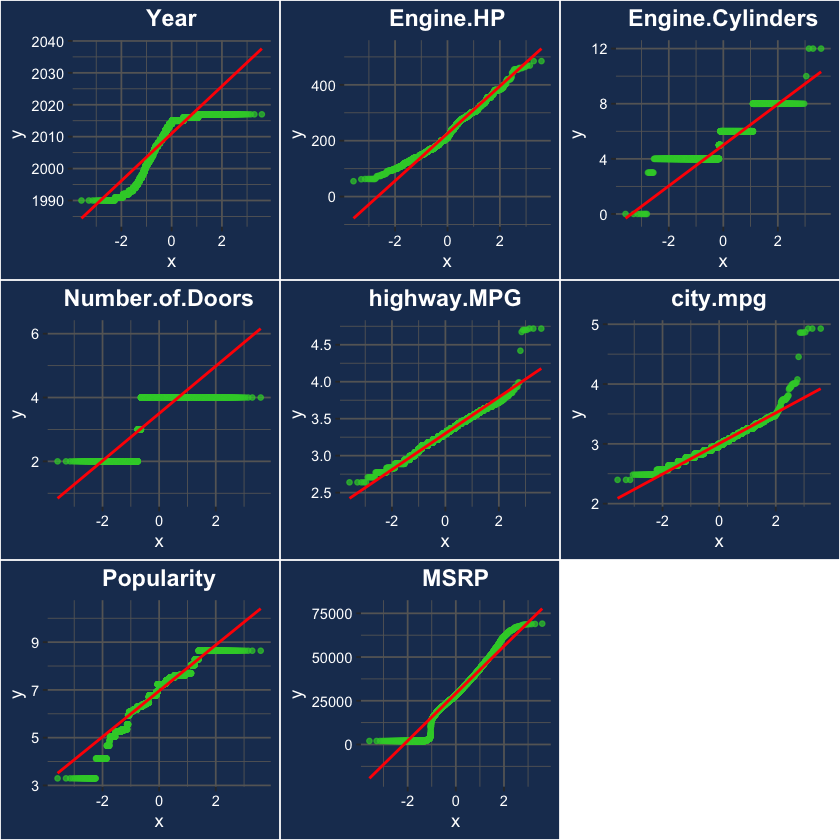

In [17]:
# Filter numeric variables
numeric_vars <- dat[, sapply(dat, is.numeric)]

# Define a custom theme for the plots
custom_theme <- theme(
  plot.title = element_text(hjust = 0.5, face = "bold", size = 14, color = "white"),
  panel.background = element_rect(fill = "#1E3A5F"), # Dark blue background
  panel.grid = element_line(color = "gray40"),
  axis.text = element_text(color = "white"),
  axis.title = element_text(color = "white"),
  plot.background = element_rect(fill = "#1E3A5F"),
  legend.position = "none"
)

# Create Q-Q plots for all numeric variables
qq_plots <- lapply(names(numeric_vars), function(var) {
  ggplot(dat, aes(sample = !!sym(var))) +
    stat_qq(color = "limegreen", size = 1.2, alpha = 0.7) +
    stat_qq_line(color = "red", size = 0.8) +
    ggtitle(var) +
    custom_theme
})

# Arrange plots into a grid
grid.arrange(grobs = qq_plots, ncol = 3)


Box's M Test for check the homogeneity of covariance .

In [18]:
library(MVTests)
with(dat,BoxM(cbind(Engine.HP,highway.MPG,city.mpg),group = MSRP_Group ))


Attaching package: 'MVTests'


The following object is masked from 'package:datasets':

    iris




$Chisq
[1] 272.9134

$df
[1] 12

$p.value
[1] 2.236063e-51

$Test
[1] "BoxM"

attr(,"class")
[1] "MVTests" "list"

# Since p-value is too small, assumption of homogeneity of covariance matrices is not met.


In [ ]:
# Test for multivariate normality
# result <- mvn(data = dat[, c("Engine.HP", "highway.MPG", "city.mpg")], mvnTest = "mardia")
# print(result)

In [19]:
library(MVN)



result2 <- mvn(data =  num_dat, mvnTest = "mardia")
print(result2)


$multivariateNormality
             Test        Statistic p value Result
1 Mardia Skewness 36931.8586643137       0     NO
2 Mardia Kurtosis 411.263872706018       0     NO
3             MVN             <NA>    <NA>     NO

$univariateNormality
              Test         Variable Statistic   p value Normality
1 Anderson-Darling       Year        781.8139  <0.001      NO    
2 Anderson-Darling    Engine.HP       84.5280  <0.001      NO    
3 Anderson-Darling Engine.Cylinders  946.5415  <0.001      NO    
4 Anderson-Darling Number.of.Doors  2347.0138  <0.001      NO    
5 Anderson-Darling   highway.MPG      16.9793  <0.001      NO    
6 Anderson-Darling     city.mpg       58.8634  <0.001      NO    
7 Anderson-Darling    Popularity     166.2493  <0.001      NO    
8 Anderson-Darling       MSRP         90.8365  <0.001      NO    

$Descriptives
                     n          Mean Std.Dev       Median       Min        Max
Year             10736  3.037436e-15       1  0.508557302 -2.568654

# Non-normality and skewness/kurtosis patterns indicate that the data is not suitable for MANOVA.
# This dataset is not met the normality assumption >> not suitable for MANOVA & LDA

In [20]:
cor(num_dat[,c(2,5,6)])

,Engine.HP,highway.MPG,city.mpg
Engine.HP,1.0000000,-0.4106914,-0.4937967
highway.MPG,-0.4106914,1.0000000,0.9349040
city.mpg,-0.4937967,0.9349040,1.0000000


             Df  Pillai approx F num Df den Df    Pr(>F)    
MSRP_Group    2 0.58851   624.79      4   5994 < 2.2e-16 ***
Residuals  2997                                             
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call: mardia(x = manova_fit$residuals)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 3000   num.vars =  2 
b1p =  2.62   skew =  1307.78  with probability  <=  6.9e-282
 small sample skew =  1309.96  with probability <=  2.3e-282
b2p =  18.06   kurtosis =  68.86  with probability <=  0

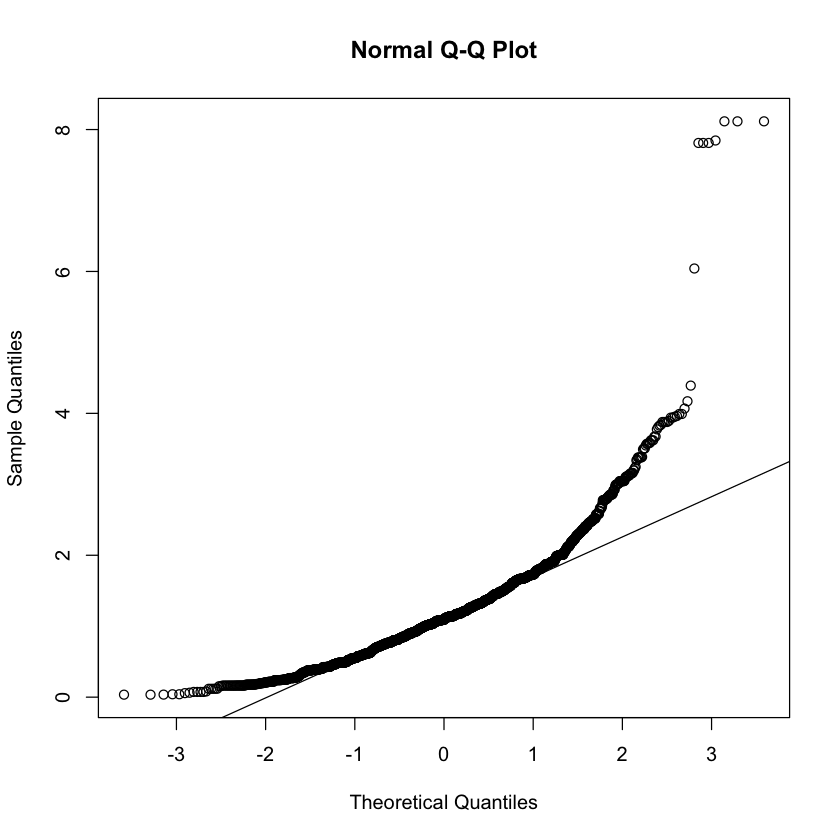

In [21]:
manova_fit= manova(cbind(city.mpg,Engine.HP) ~ MSRP_Group , data = dat)
summary(manova_fit)
mardia(manova_fit$residuals)

# 2) PCA

3 Approaches

Commonly used methods to select the number of components include:

1. Selecting components corresponding to eigenvalues greater than 1.

In [22]:
set.seed(123)
fit = prcomp(num_dat)
mat= cov(num_dat)
eigen(mat)

PC1=fit$rotation[,1]
# round(PC1,3)
PC2=fit$rotation[,2]

mat= cov(num_dat)
eigen(mat)

eigen() decomposition
$values
[1] 3.15268344 2.29665929 1.05314922 0.83791843 0.29398380 0.18119450 0.12675575
[8] 0.05765556

$vectors
             [,1]        [,2]         [,3]        [,4]        [,5]        [,6]
[1,] -0.035729572  0.61083510 -0.097936052 -0.05511614  0.37005485  0.68854547
[2,]  0.441907751  0.33841305 -0.027269565 -0.17758462 -0.27301791 -0.10022561
[3,]  0.513857461 -0.02838501 -0.003295822  0.02286629 -0.62468698  0.35951645
[4,] -0.008396724  0.29320219  0.463409860  0.82682983 -0.07671468 -0.08428710
[5,] -0.484268387  0.25605606 -0.016442415 -0.14769241 -0.46576374 -0.01817237
[6,] -0.505093862  0.21986399 -0.042000359 -0.08024815 -0.39149477 -0.02156459
[7,]  0.021935629  0.07287175 -0.878923050  0.44918530 -0.04032877 -0.13110468
[8,]  0.221819951  0.55350581  0.019110954 -0.22635198  0.14342678 -0.60126522
             [,7]        [,8]
[1,]  0.042821957 -0.01026873
[2,] -0.734885296  0.18241126
[3,]  0.461077741 -0.05032384
[4,] -0.049649966 -0.01054133
[5,

2. Choosing components that collectively explain at least 80% (or around) of the original variance.

In [23]:
summary(fit)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.7756 1.5155 1.0262 0.9154 0.54220 0.42567 0.35603
Proportion of Variance 0.3941 0.2871 0.1316 0.1047 0.03675 0.02265 0.01584
Cumulative Proportion  0.3941 0.6812 0.8128 0.9175 0.95430 0.97695 0.99279
                           PC8
Standard deviation     0.24012
Proportion of Variance 0.00721
Cumulative Proportion  1.00000

3. Examining the point of inflection in the scree plot, which signifies diminishing returns in explaining additional variance.

In [ ]:
library(factoextra)

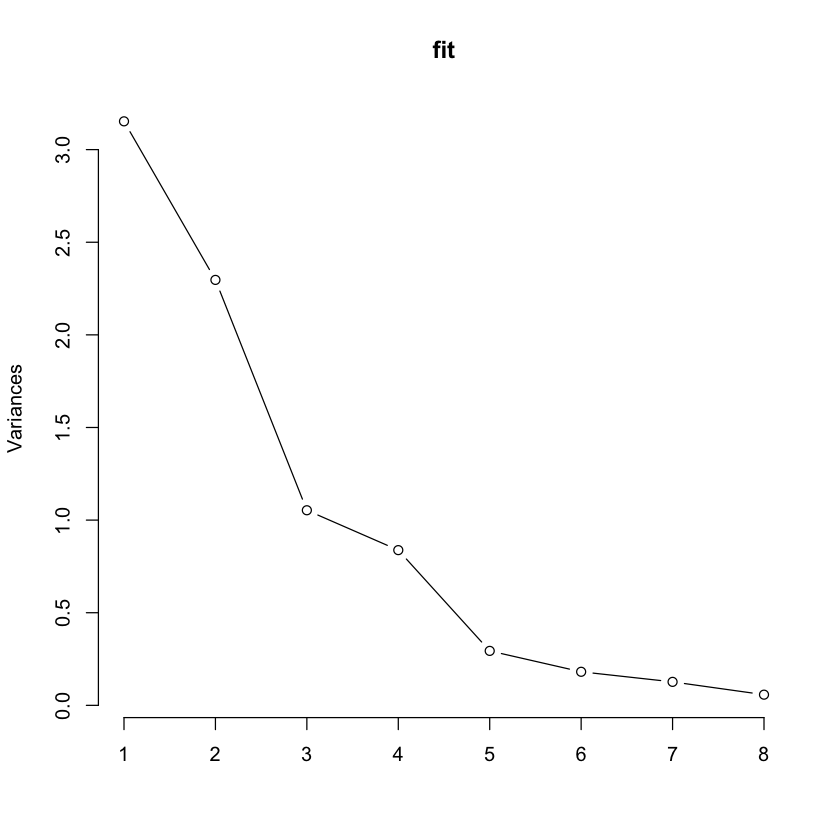

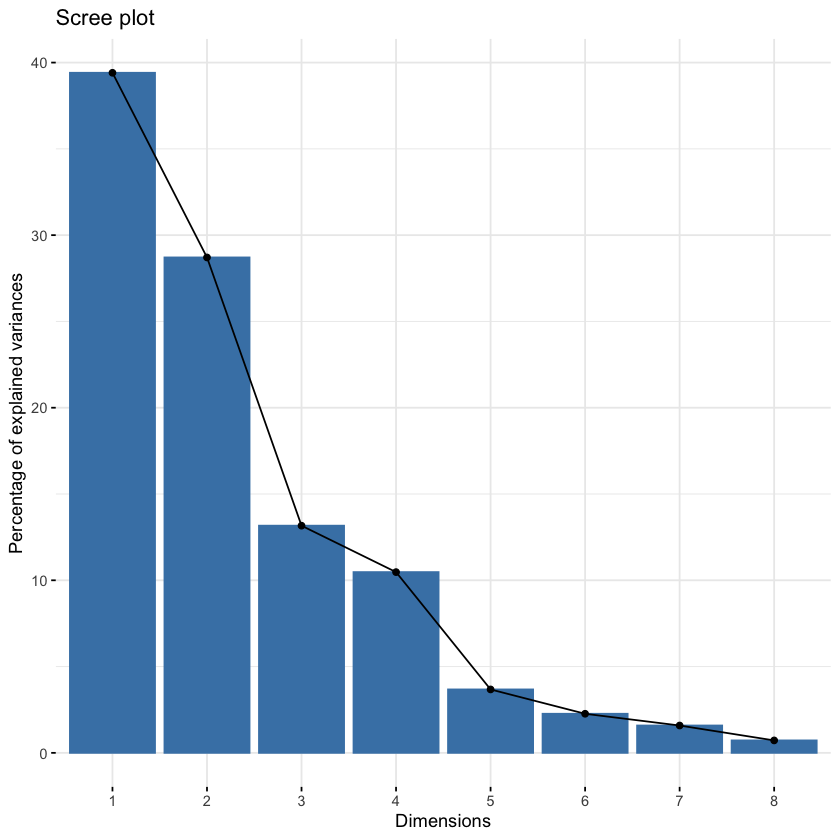

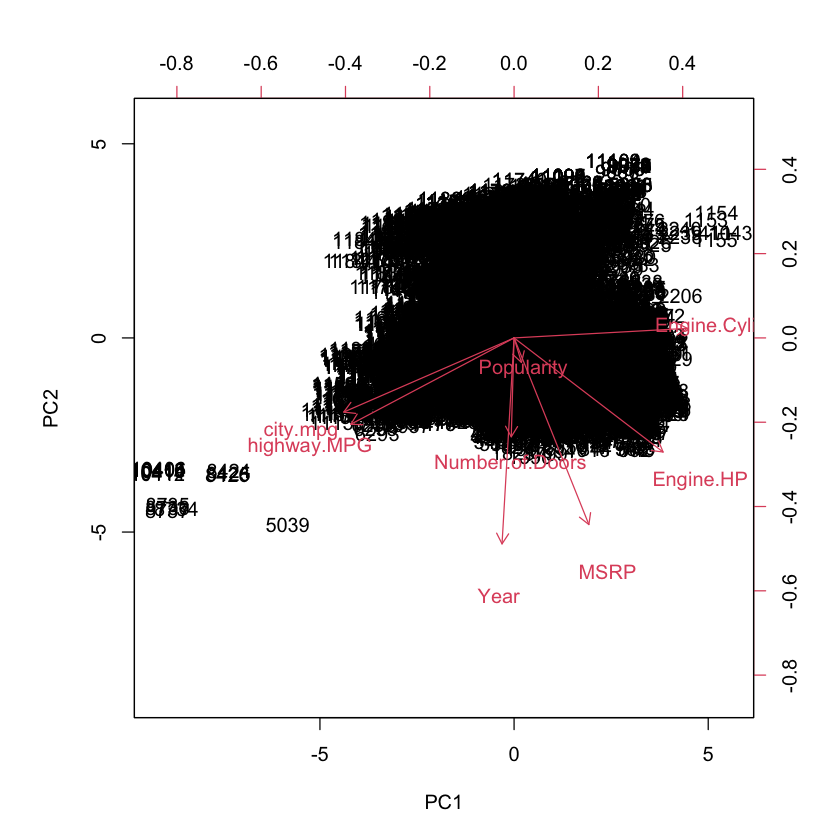

In [24]:
set.seed(123)
#spree plot
plot.pca = plot(fit, type="l") #type="l" is for line plot

#additional spree plot to visualize the result of PCA

fviz_eig(fit)
biplot(fit, scale=0)

# 3) Factor Analysis

Parallel analysis suggests that the number of factors =  4  and the number of components =  NA 


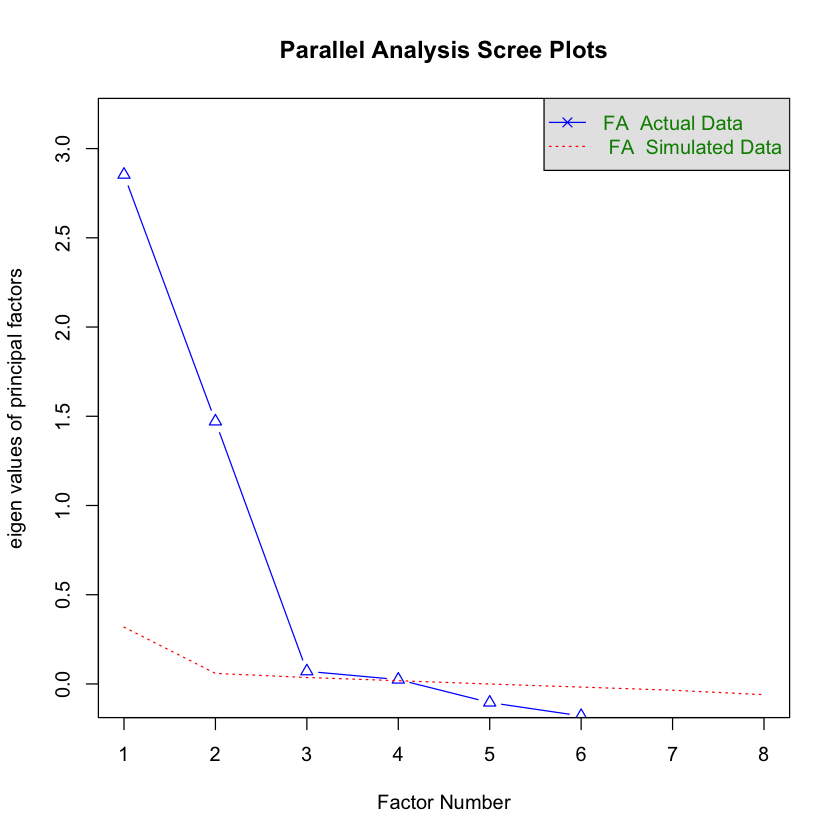

In [25]:
cor1 = cor(num_dat,use="pairwise.complete.obs")
fa.parallel(x = cor1, n.obs = 3000, fm = "minres", fa = "fa")

In [26]:
fit.fa = factanal(~., data=num_dat, factors=4, rotation="varimax", na.action = na.exclude)
fit.fa
fa.diagram(fit.fa$loadings)


Call:
factanal(x = ~., factors = 4, data = num_dat, na.action = na.exclude,     rotation = "varimax")

Uniquenesses:
            Year        Engine.HP Engine.Cylinders  Number.of.Doors 
           0.097            0.005            0.252            0.870 
     highway.MPG         city.mpg       Popularity             MSRP 
           0.037            0.077            0.005            0.224 

Loadings:
                 Factor1 Factor2 Factor3 Factor4
Year              0.280   0.287   0.846   0.162 
Engine.HP        -0.416   0.854   0.302         
Engine.Cylinders -0.709   0.489                 
Number.of.Doors                   0.353         
highway.MPG       0.970           0.136         
city.mpg          0.936  -0.171   0.133         
Popularity                                0.997 
MSRP                      0.593   0.648         

               Factor1 Factor2 Factor3 Factor4
SS loadings      2.576   1.437   1.393   1.026
Proportion Var   0.322   0.180   0.174   0.128
Cumulative V

# add the interpretation of factor 1, 2 

 Factor 1 (Fuel Efficiency/Engine Characteristics) or Factor 2 (Performance/Luxury Features).

- Factor 1 focuses on fuel efficiency and engine design, capturing practical and economic aspects of vehicles.
- Factor 2 emphasizes performance and luxury, highlighting aspects that cater to high-end or powerful vehicle markets.

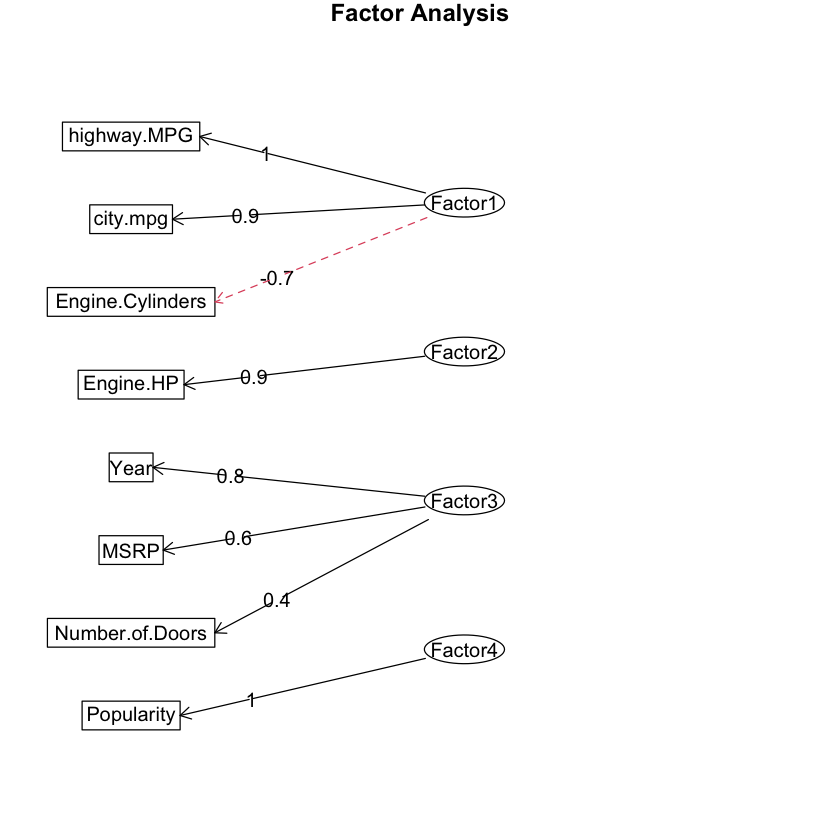

In [27]:
#visualize the loadings of the factor analysis result
fa.diagram(fit.fa$loadings)

# Discriminant Analysis

In [28]:
rm(list = ls())
gc() 

# load the data
data <- read.csv("data.csv")
#sum(is.na(data))  # Total number of missing values in the dataset
dat <- na.omit(data)  # remove rows with missing values

# # Function to remove outliers using IQR method
# remove_outliers <- function(data, cols) {
#   for (col in cols) {
#     Q1 <- quantile(data[[col]], 0.25, na.rm = TRUE)  # 1st Quartile (25%)
#     Q3 <- quantile(data[[col]], 0.75, na.rm = TRUE)  # 3rd Quartile (75%)
#     IQR <- Q3 - Q1                                  # Interquartile Range
    
#     # Define lower and upper bounds
#     lower_bound <- Q1 - 1.5 * IQR
#     upper_bound <- Q3 + 1.5 * IQR
    
#     # Filter rows within bounds
#     data <- data[data[[col]] >= lower_bound & data[[col]] <= upper_bound, ]
#   }
#   return(data)
# }

# # Columns to check for outliers
# numeric_cols <- c("Engine.HP", "Engine.Cylinders", "highway.MPG", "city.mpg", "Popularity", "MSRP")

# # Apply function to remove outliers
# dat <- remove_outliers(dat, numeric_cols)

set.seed(123)
# Sample 3000 observations
dat <- dat[sample(1:nrow(dat), 3000, replace = FALSE), ]


dat <- dat %>% 
mutate(across(c(Year,city.mpg, highway.MPG, Engine.HP,MSRP,Popularity), ~ log1p(.)))


num_dat = dat[,c(3,5,6,9,13,14,15,16)]
# num_dat <- scale(num_dat) 

num_dat = data.frame(scale(num_dat,center=TRUE,scale = TRUE))



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1874367,100.2,3327260,177.7,NA,3327260,177.7
Vcells,3391413,25.9,226506086,1728.2,16384,273039364,2083.2


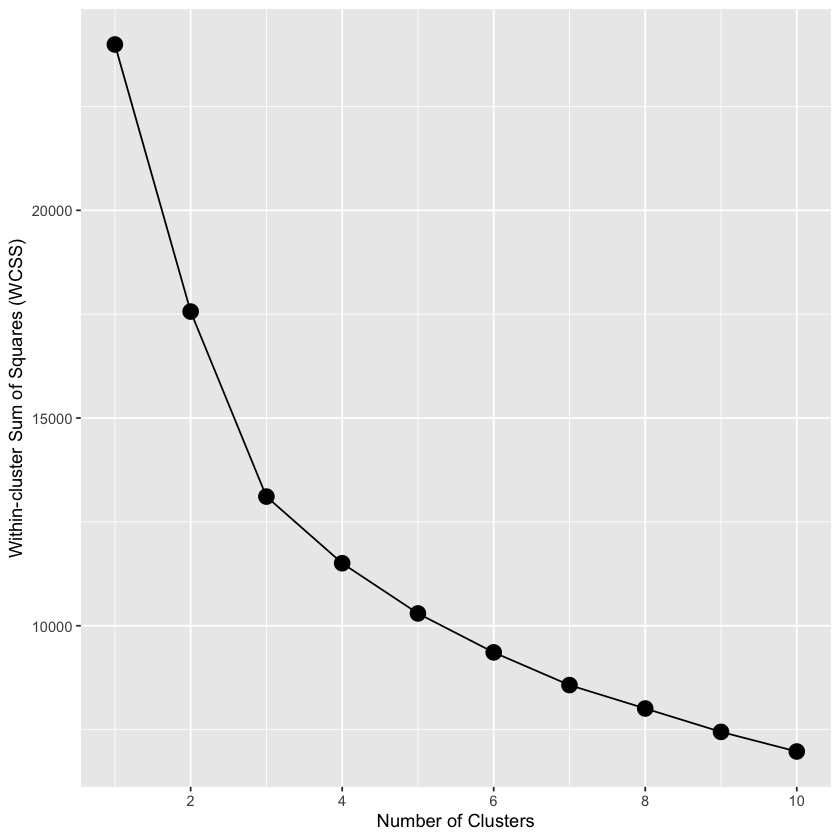

In [30]:
# Decide the number of clusters
n_clusters <- 10

# Initialize a vector to store within-cluster sum of squares (WSS) for each model
wss <- numeric(n_clusters)

set.seed(123)

# Test models with 1 to n_clusters
for (i in 1:n_clusters) {
  km.out <- kmeans(num_dat, centers=i, nstart=20) # Fit k-means model
  wss[i] <- km.out$tot.withinss             # Store WSS for the current model
}

# Prepare data for plotting
wss_df <- tibble(k=1:n_clusters, wss=wss) # Create a tibble with results

# Create the scree plot
scree_plot <- ggplot(wss_df, aes(x=k, y=wss)) + # Correct variable names
  geom_point(size=4) +
  geom_line() +
  scale_x_continuous(breaks = c(2, 4, 6, 8, 10)) +
  xlab('Number of Clusters') +
  ylab('Within-cluster Sum of Squares (WCSS)')

# Display the scree plot
scree_plot


# the optimal number of clusters is 3 (the elbow point is 3)
# ( decrease in the within groups sum of squares is not significant after 3 clusters)  

In [31]:
fit.3 = kmeans(x=num_dat, centers = 3)
# fit.4 = kmeans(x=num_dat,centers=4)

effect of variables:
 modified item       Var               
 "height of face   " "Year"            
 "width of face    " "Engine.HP"       
 "structure of face" "Engine.Cylinders"
 "height of mouth  " "Number.of.Doors" 
 "width of mouth   " "highway.MPG"     
 "smiling          " "city.mpg"        
 "height of eyes   " "Popularity"      
 "width of eyes    " "MSRP"            
 "height of hair   " "Year"            
 "width of hair   "  "Engine.HP"       
 "style of hair   "  "Engine.Cylinders"
 "height of nose  "  "Number.of.Doors" 
 "width of nose   "  "highway.MPG"     
 "width of ear    "  "city.mpg"        
 "height of ear   "  "Popularity"      


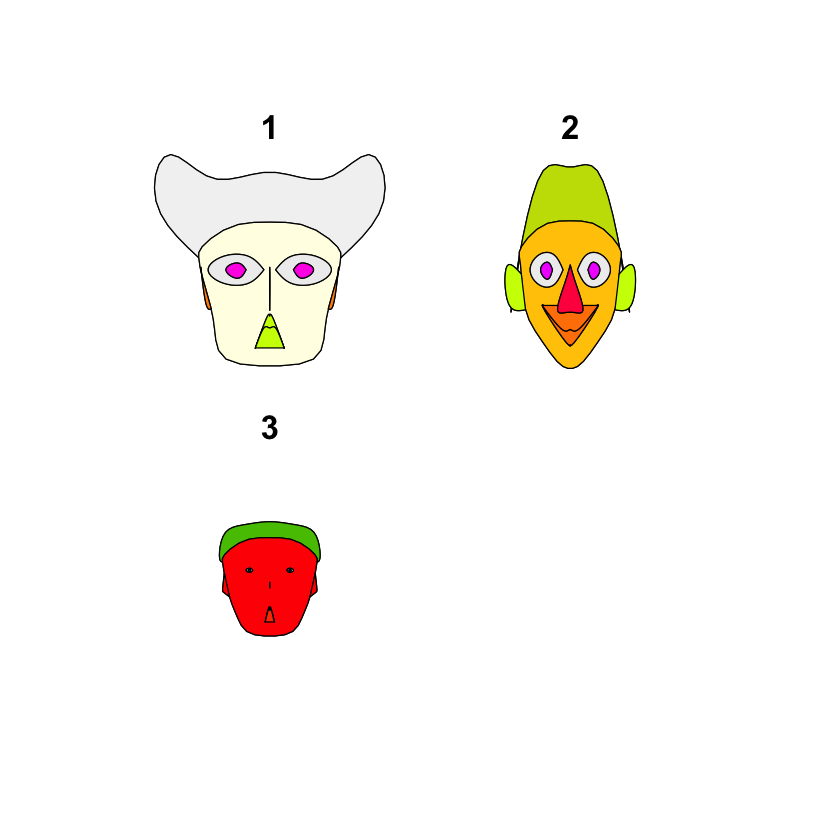

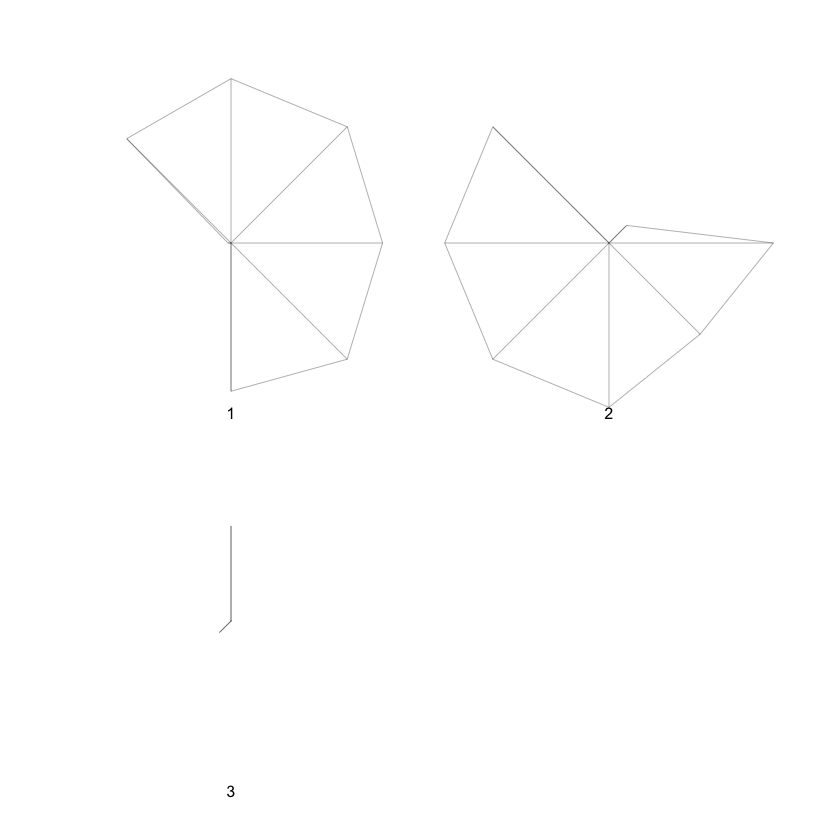

In [33]:
#face plot
faces(fit.3$centers)
stars(fit.3$centers)

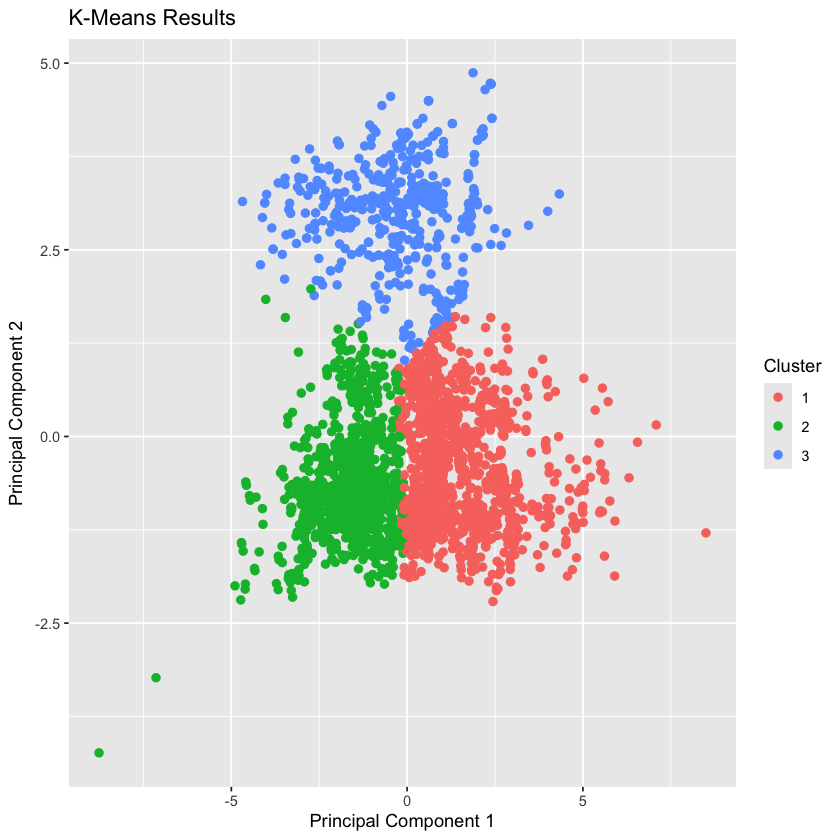

In [34]:
plot(fit.3,data=num_dat)

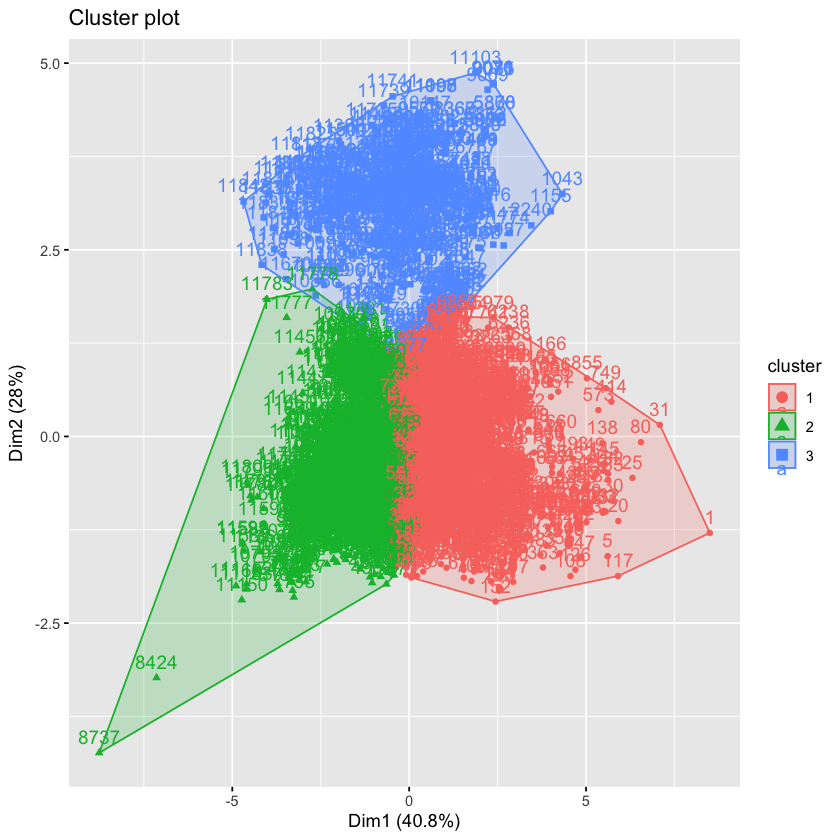

In [35]:
set.seed(123)
fviz_cluster(fit.3, data=num_dat) 

In [ ]:
fit.3 = kmeans(x=num_dat, centers = 3)
faces(fit.3$centers)
plot(fit.3,data=num_dat)
fviz_cluster(fit.3, data=num_dat)